In [1]:
import transformers, datasets
transformers.utils.logging.set_verbosity_error()
datasets.utils.logging.set_verbosity_error()

# Nonparametric quantification of uncertainty of text classification models using conformal prediction

## Dataset

### Loading

In [2]:
from datasets import load_dataset
import numpy as np
dataset = load_dataset('amazon_polarity')

smaller_dataset = dataset
smaller_dataset["train"] = smaller_dataset["train"].filter(lambda e, i: i<18000, with_indices=True)
smaller_dataset["test"] = smaller_dataset["test"].filter(lambda e, i: i<2000, with_indices=True)

  0%|          | 0/2 [00:00<?, ?it/s]

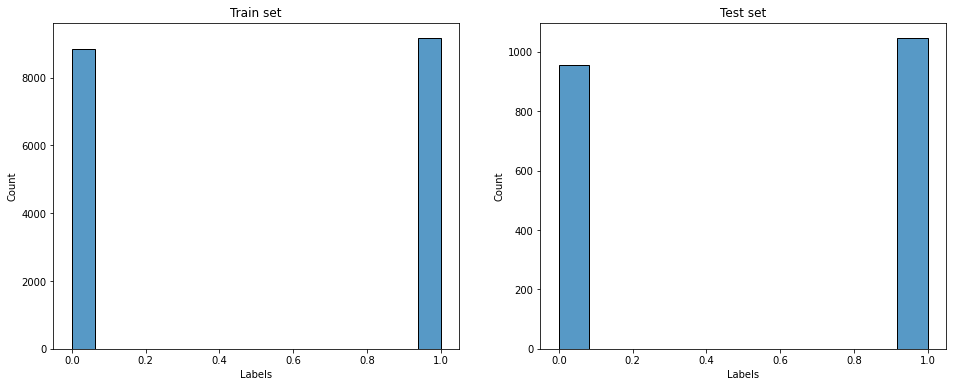

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.histplot(smaller_dataset["train"]["label"], ax=ax[0])
sns.histplot(smaller_dataset["test"]["label"], ax=ax[1])
ax[0].set_xlabel('Labels'); ax[1].set_xlabel('Labels');
ax[0].set_title('Train set'); ax[1].set_title('Test set');

### BERT Tokenizer

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def preprocess_function(examples):
    return tokenizer(examples["title"], truncation=True)

In [5]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)
smaller_tokenized_dataset = smaller_dataset.map(preprocess_function, batched=True)

## Model

### BERT

In [ ]:
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

In [ ]:
from transformers import TrainingArguments, Trainer
from datasets import load_metric

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=smaller_tokenized_dataset["train"],
    eval_dataset=smaller_tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

In [ ]:
trainer.save_model('bert')

**Load pretrained model**

In [6]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained('./bert/')

from transformers import TextClassificationPipeline
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=smaller_tokenized_dataset["train"],
    eval_dataset=smaller_tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [7]:
import torch
predicted = trainer.predict(smaller_tokenized_dataset["test"])

predicted_proba = torch.tensor(predicted.predictions)

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: title, content.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


In [8]:
data_bert = predicted_proba[:,1].numpy(), np.array(smaller_tokenized_dataset["test"]["label"])

<AxesSubplot:ylabel='Count'>

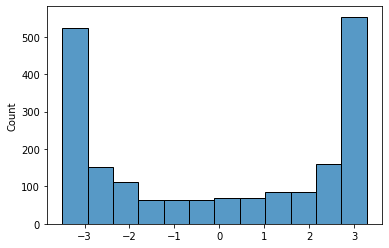

In [9]:
import seaborn as sns
sns.histplot(data_bert[0])

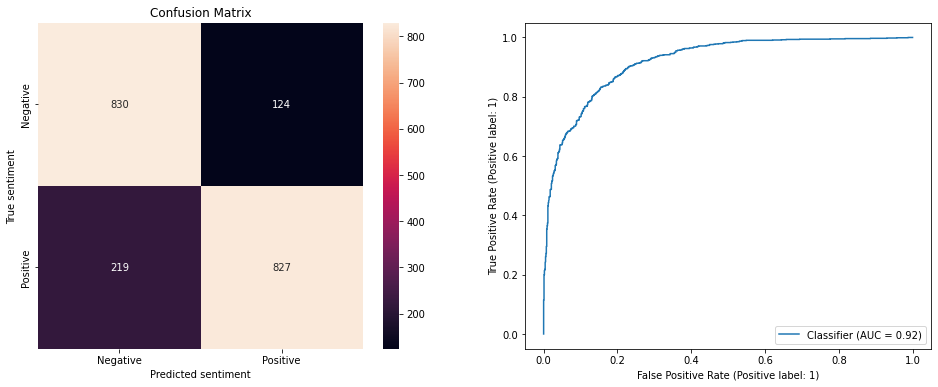

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt     

threshold = 0.5
y_hat = (data_bert[0] > threshold).astype('float')

fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(confusion_matrix(data_bert[1], y_hat), annot=True, fmt='g', ax=ax[0])
ax[0].set_xlabel('Predicted sentiment'); ax[0].set_ylabel('True sentiment')
ax[0].set_title('Confusion Matrix')
ax[0].xaxis.set_ticklabels(['Negative', 'Positive']); ax[0].yaxis.set_ticklabels(['Negative', 'Positive'])

from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(data_bert[1], predicted_proba[:,1], ax=ax[1])

## Evaluation

**Supporting code**

In [11]:
import VennAbers
from sklearn.isotonic import IsotonicRegression
import seaborn as sns
import matplotlib.pyplot as plt
from math import floor, ceil, exp
from sklearn.calibration import CalibratedClassifierCV

def plot_all_score(data):
    rng = np.array(list(range(floor(data[0].min()*100), ceil(data[0].max()*100), 1))) / 100
    venn_abers = VennAbers.venn_abers_fast(list(zip(data[0], data[1])), rng)
    ir = IsotonicRegression()
    ir.fit(data[0], data[1])
    predicted_proba = ir.predict(rng)
    
    ps = CalibratedClassifierCV()
    ps.fit(data[0].reshape(-1, 1), data[1])
    platt_scaling = ps.predict_proba(rng.reshape(-1, 1))[:,1]
    
    plt.figure(figsize=(10,10))
    sns.lineplot(x=rng, y=(venn_abers[0] + venn_abers[1]) / 2)
    plt.fill_between(rng, venn_abers[0], venn_abers[1], alpha=.15)
    sns.lineplot(x=rng, y=predicted_proba, linestyle='dotted')
    sns.lineplot(x=rng, y=platt_scaling)
    plt.axis((floor(data[0].min()), ceil(data[0].max()), 0, 1))
    
    #xpoints = ypoints = plt.xlim()
    #plt.plot(xpoints, ypoints, linestyle='--', color='grey', lw=1, scalex=False, scaley=False)
    
    plt.xticks(np.arange(floor(data[0].min()), ceil(data[0].max())+0.1, step=0.5))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.legend(["Venn-Abers", "Venn-Abers Interval", "Isotonic Regression", "Platt Scaling"])
    plt.xlabel('Model probability'); plt.ylabel('Calibrated probability')

### BERT

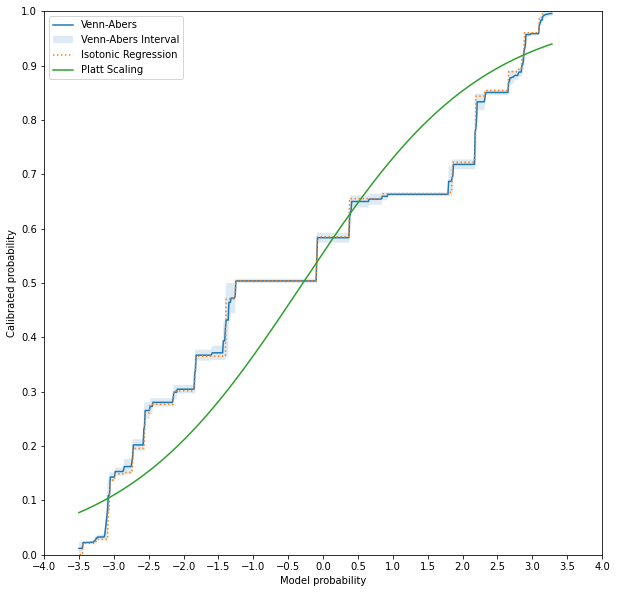

In [12]:
plot_all_score(data_bert)

## Time evaluation

In [13]:
import time
import VennAbers
from tqdm import tqdm
data_time_eval = data_bert

In [14]:
def time_eval_slow(rounds=100):
    total_time = 0
    for i in range(rounds):
        start = time.time()
        for s_x_test in (np.array(list(range(0, 101, 1))) / 100):
            venn_abers = VennAbers.venn_abers(list(zip(data_time_eval[0], data_time_eval[1])), s_x_test)
        end = time.time()
        total_time += end - start
    return total_time / rounds * 1000

In [15]:
def time_eval_fast(rounds=100):
    total_time = 0
    for i in range(rounds):
        start = time.time()
        venn_abers = VennAbers.venn_abers_fast(list(zip(data_time_eval[0], data_time_eval[1])), np.array(list(range(0, 101, 1))) / 100)
        end = time.time()
        total_time += end - start
    return total_time / rounds * 1000

In [16]:
time_slow, time_fast = time_eval_slow(), time_eval_fast()
print(f"Slow Venn-Abers (avg. - 100 runs): {round(time_slow)} ms")
print(f"Fast Venn-Abers (avg. - 100 runs): {round(time_fast)} ms")
print(f"Average speed-up of {round((1/time_fast) / (1/time_slow), 1)}x (100 runs)")

Slow Venn-Abers (avg. - 100 runs): 168 ms
Fast Venn-Abers (avg. - 100 runs): 82 ms
Average speed-up of 2.1x (100 runs)
